In [16]:
# Copyright Tay Zhi Cong, year 2025

import numpy as np 
import matplotlib.pyplot as plt 
from scipy import signal 
import math

#### Appendix: Method to obtain low pass filter tap coeffiecients

In [66]:
def get_low_pass_filter_tap_coeffiecients_using_kaiser_window_design(stop_band_attenuation, f_sampling, f_transition, f_minus_6db, filter_length):
    beta = signal.kaiser_beta(stop_band_attenuation) # 1. calculate the kaiser beta
    # filter_length = math.ceil((f_sampling/f_transition) * (stop_band_attenuation-8)/14) # 2. estimate the filter length : N ~= f_sampling/ f_transition * (Attenuation (in dB) - 8) / 14
    filter_tap = signal.windows.kaiser(filter_length, beta=beta)
    h = np.sinc(2*f_minus_6db/f_sampling*np.linspace(-(filter_length - 1)/2,(filter_length - 1)/2,filter_length))*filter_tap
    h = h/sum(h)
    return h

def plot_filter_to_verify_spec(h, num_fft, f_sampling):
    freq_response = np.fft.fft(h, num_fft)
    freq = np.arange(0, len(freq_response), 1)/len(freq_response) * f_sampling

    plt.figure()
    ax = plt.subplot(1,2,1)
    plt.plot(freq, 20 * np.log10(abs(freq_response)), 'C0')
    plt.grid(which="major")
    plt.grid(which="minor")
    plt.minorticks_on()
    ax.set_xlim(0, 50)
    ax.set_ylim(-80, 1)
    
    ax = plt.subplot(2,2,2)
    plt.plot(freq, 20 * np.log10(abs(freq_response)), 'C0')
    plt.grid(which="major")
    plt.grid(which="minor")
    plt.minorticks_on()
    
    # Define the desired zoom region
    x_min, x_max = 0, 15
    y_min, y_max = -0.1, 0.1
    
    # Set the x and y limits of the axes to zoom to the rectangle
    # ax.set_xlim(x_min, x_max)
    # ax.set_ylim(y_min, y_max)
    
    
    ax = plt.subplot(2,2,4)
    plt.plot(freq, 20 * np.log10(abs(freq_response)), 'C0')
    plt.grid(which="major")
    plt.grid(which="minor")
    plt.minorticks_on()
    
    # Define the desired zoom region
    x_min, x_max = 11, 22
    y_min, y_max = -80, -60
    
    # Set the x and y limits of the axes to zoom to the rectangle
    # ax.set_xlim(x_min, x_max)
    # ax.set_ylim(y_min, y_max)


#### Designing a five path polyphase downsampling filter with the following spec:

Input sample rate: 100kHz \
Output sample rate: 20kHz \
Pass band: 0 - 8kHz \
Stop band: 12 - 50kHz \
In-band ripple: 0.1dB \
Stop-band attennuation: 60dB


#### Step 1: Get the filter taps coefficients that meet the spec

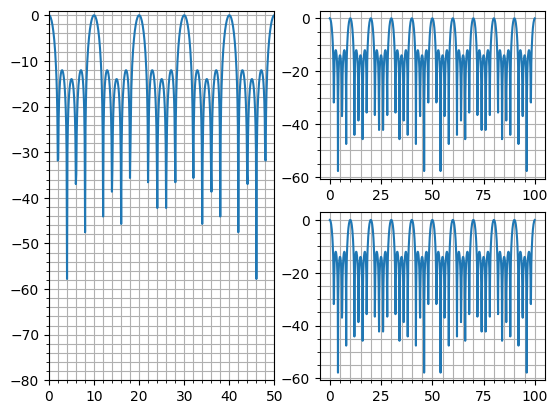

In [67]:
stop_band_attenuation = 60
f_sampling = 100
f_transition = 4
f_minus_6db = 10
low_pass_filter_length = 95 # use 93
num_fft = 1024

h = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
h = h/sum(h)
plot_filter_to_verify_spec(h, num_fft, f_sampling)


#### Step 2: Partition the filter tap coefficients to form a ten-path polyphase filter

[0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0. ]


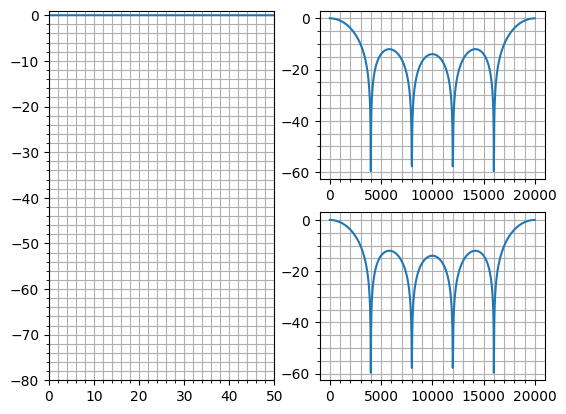

In [68]:
h_padded = np.hstack((h, np.zeros(9)))
print(h_padded)
h_partitioned = np.reshape(h_padded, (5, 10))
plot_filter_to_verify_spec(h_partitioned[:,0], num_fft, 20000)

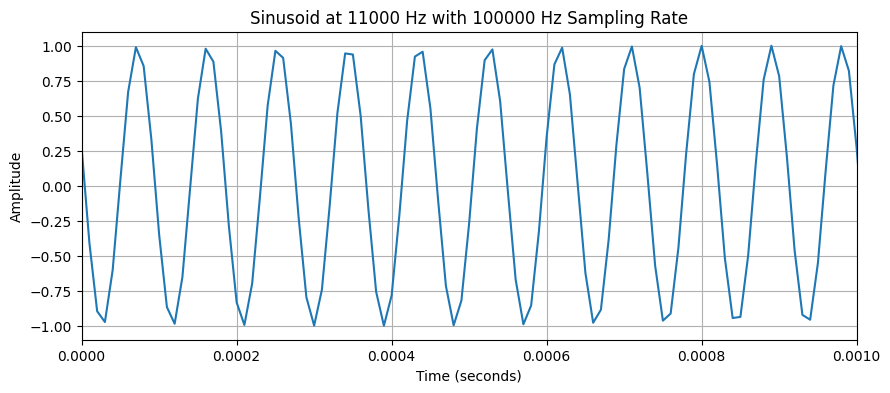

In [56]:
def generate_sinusoid(frequency, sample_rate, num_samples):
    # Calculate duration
    # num_samples = int(sample_rate * duration)
    duration = num_samples / sample_rate

    # Create the time axis
    t = np.linspace(0, duration, num_samples, endpoint=False)
    random_phase = np.random.uniform(0, 2 * np.pi)
    sinusoid = np.sin(2 * np.pi * frequency * t + random_phase)
    
    return t, sinusoid

# Define parameters for the sinusoid
signal_frequency = 11000  # Hz
sampling_rate = 100000   # Hz (must be at least twice the signal_frequency according to Nyquist-Shannon)
number_of_samples = 500

# Generate the sinusoid
time_axis, signal_data = generate_sinusoid(signal_frequency, sampling_rate, number_of_samples)

# Plotting the generated sinusoid
plt.figure(figsize=(10, 4))
plt.plot(time_axis, signal_data)
plt.title(f'Sinusoid at {signal_frequency} Hz with {sampling_rate} Hz Sampling Rate')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(0, 0.001)
plt.show()



(540,)


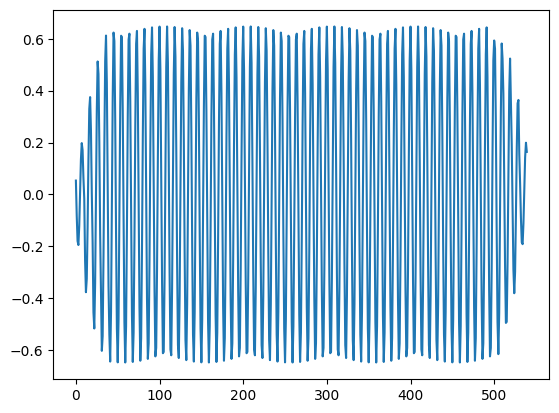

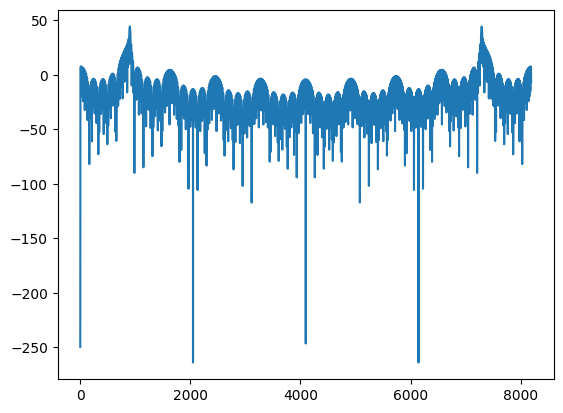

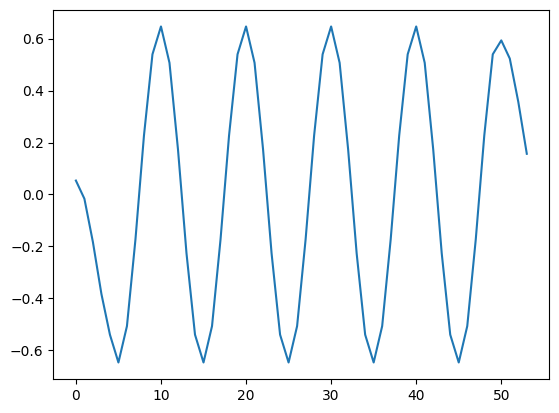

In [62]:
out = np.convolve(signal_data, h)
plt.figure()
plt.plot(out)
plt.figure()
plt.plot(20*np.log10(abs(np.fft.fft(out, 1024*8))))

# discard samples
# out = out[20:-20]
print(out.shape)
out_reshaped = np.reshape(out, (54,10))
plt.figure()
plt.plot(out_reshaped[:,0])


#### Step 3: pass the 10-to-1 down sampled input series through the 10-to-1 down sampled filter and plot the output time response.


signal_data_reshaped shape (50, 10)
h_partitioned shape (5, 10)
first_path_result shape (54,)


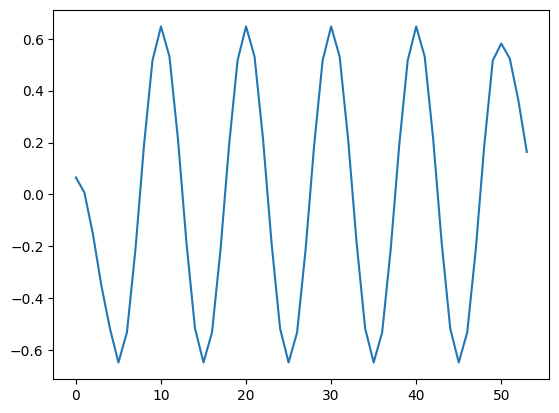

In [64]:
signal_data_reshaped = np.reshape(signal_data, (50,10))

first_path_result = np.convolve(signal_data_reshaped[:,9], h_partitioned[:,0])
second_path_result = np.convolve(signal_data_reshaped[:,8], h_partitioned[:,1])
third_path_result = np.convolve(signal_data_reshaped[:,7], h_partitioned[:,2])
forth_path_result = np.convolve(signal_data_reshaped[:,6], h_partitioned[:,3])
fifth_path_result = np.convolve(signal_data_reshaped[:,5], h_partitioned[:,4])
out = first_path_result+second_path_result+third_path_result+forth_path_result+fifth_path_result

print("signal_data_reshaped shape", signal_data_reshaped.shape)
print("h_partitioned shape", h_partitioned.shape)
print("first_path_result shape", first_path_result.shape)
plt.figure()
plt.plot(first_path_result)
